In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                          Dropout, Rescaling, RandomFlip, RandomRotation, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = np.loadtxt('../input/digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../input/digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [4]:
train_label = train[:, 0]

train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Let’s visualize few data from training

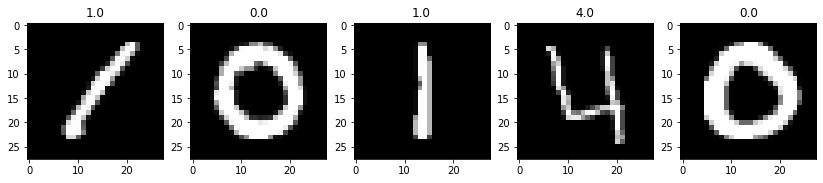

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Check disbalance target classes

In [6]:
unique, counts = np.unique(train_label, return_counts=True)
print(unique, counts)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]


In [7]:
for i in range(len(unique)):
    print(f'Digit {i}: {counts[i] / len(train_label) * 100} %')

Digit 0: 9.838095238095237 %
Digit 1: 11.152380952380952 %
Digit 2: 9.945238095238096 %
Digit 3: 10.359523809523811 %
Digit 4: 9.695238095238096 %
Digit 5: 9.035714285714286 %
Digit 6: 9.85 %
Digit 7: 10.47857142857143 %
Digit 8: 9.673809523809524 %
Digit 9: 9.971428571428572 %


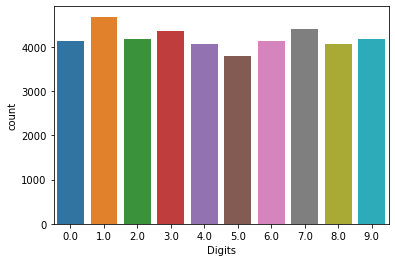

In [8]:
sns.countplot(x=train_label)
plt.xlabel('Digits')
plt.show;

## Reacale images

In [9]:
rescale = Sequential([
  Rescaling(1./255)
])

2023-02-01 04:55:19.358511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 04:55:19.360032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 04:55:19.531106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 04:55:19.532009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 04:55:19.532763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

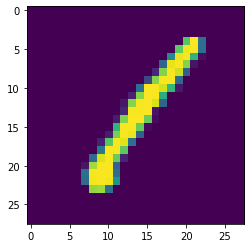

In [10]:
result = rescale(train_img[0])
_ = plt.imshow(result)

In [11]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


## Image augmentation 

In [12]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

In [13]:
image = tf.expand_dims(train_img[0], 0)

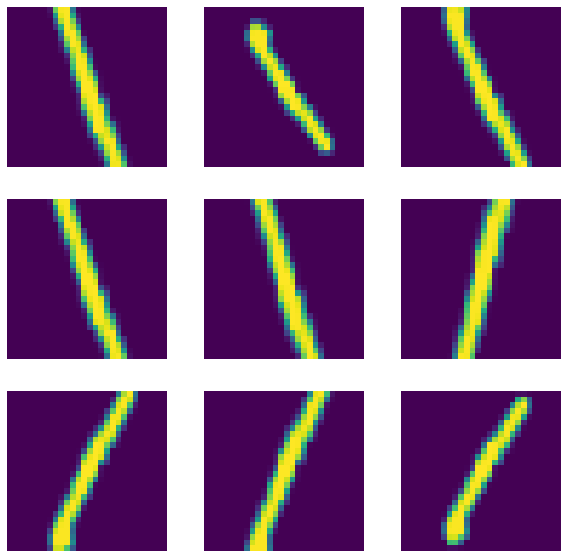

In [14]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## CNN

In [15]:
Y_train = to_categorical(train_label, num_classes = 10)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_img, Y_train, test_size = 0.2, random_state=42)

In [17]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [18]:
input_shape = (28, 28, 1)

In [19]:
width_shift_val = 0.1
height_shift_val = 0.1
shear_range_val=10
zoom_range_val= 0.1
random_rotation_val = 10
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = random_rotation_val,width_shift_range = width_shift_val,
                                                          height_shift_range = height_shift_val,zoom_range=zoom_range_val,)
datagen.fit(X_train)

In [20]:
early_stop = EarlyStopping(monitor="val_loss",min_delta=0, patience=12,
                           verbose=0,mode="min", baseline=None, restore_best_weights=True)
check = ModelCheckpoint(filepath='convnet.keras', save_best_only=True, monitor='val_loss')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', 
                 activation ='relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation = "softmax"))

In [22]:
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [24]:
batch_size = 64
num_epoch = 30
model_log = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                      epochs=num_epoch,
                      verbose=1,
                      validation_data=(X_test, y_test),
                      callbacks = [early_stop, check, learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-02-01 04:55:24.735690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-01 04:55:27.738022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 24s 26ms/step - loss: 0.5457 - accuracy: 0.8256 - val_loss: 0.0918 - val_accuracy: 0.9717
Epoch 2/30
525/525 [==============================] - 12s 23ms/step - loss: 0.1287 - accuracy: 0.9605 - val_loss: 0.0566 - val_accuracy: 0.9826
Epoch 3/30
525/525 [==============================] - 12s 23ms/step - loss: 0.0850 - accuracy: 0.9744 - val_loss: 0.0394 - val_accuracy: 0.9879
Epoch 4/30
525/525 [==============================] - 13s 25ms/step - loss: 0.0673 - accuracy: 0.9789 - val_loss: 0.0305 - val_accuracy: 0.9901
Epoch 5/30
525/525 [==============================] - 12s 23ms/step - loss: 0.0569 - accuracy: 0.9825 - val_loss: 0.0365 - val_accuracy: 0.9877
Epoch 6/30
525/525 [==============================] - 13s 24ms/step - loss: 0.0507 - accuracy: 0.9849 - val_loss: 0.0273 - val_accuracy: 0.9918
Epoch 7/30
525/525 [==============================] - 12s 23ms/step - loss: 0.0464 - accuracy: 0.9857 - val_loss: 0.0264 - val_accuracy: 0.9911
Epo

In [25]:
test = np.resize(test_img, (test_img.shape[0], 28, 28, 1))
pred = model.predict(test)
classes = pred.argmax(axis=-1)
classes

array([2, 0, 9, ..., 3, 9, 2])

In [26]:
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = classes
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [27]:
sub.to_csv('submission.csv', index = False)